# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [42]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

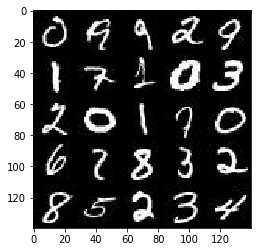

In [43]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

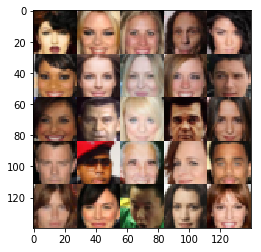

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [46]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [47]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse): # finish this
        
        keep_probability = 0.8 #suggestion of reviewer
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', use_bias=False)
        x1 = tf.maximum(x1 * alpha, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_probability) #suggestion of reviewer
        # now 14x14x128
        
        # Hidden layer 2
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding ='same',use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha *x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_probability) #suggestion of reviewer
        # now 7x7x256
        
        # Hidden layer 3
        x3 = tf.layers.conv2d(x2, 512, 5, strides=1, padding ='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha *x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_probability) #suggestion of reviewer
        #now 7x7x512
        #print ('x3', x3)
        
        # flatten
        flat = tf.reshape(x3, (-1,7*7*512))
        
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [48]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        keep_probability = 0.5 #suggestion of reviewer
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
                
        # reshape to convolutional 
        x1 = tf.reshape(x1,(-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.contrib.layers.dropout(x1, keep_prob=keep_probability, is_training=is_train) #suggestion of reviewer
        # now 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.contrib.layers.dropout(x2, keep_prob=keep_probability, is_training=is_train) #suggestion of reviewer
        # now 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.contrib.layers.dropout(x3, keep_prob=keep_probability, is_training=is_train) #suggestion of reviewer
        # now 14x14x128
            
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    # label smoothing (x0.9): suggestion of reviewer
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9)) 
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print(input_real, input_z, lr)
    #print(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    #print(d_loss, g_loss)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #print(d_opt, g_opt)
    
    steps = 0
    print_every = 20
    show_every = 100
    n_images = 25
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
                       
            for batch_images in get_batches(batch_size):
                #print (batch_images[0], batch_images[1],batch_images[2],batch_images[3])
                steps += 1
                #print('max', np.max(batch_images), 'min', np.min(batch_images))
                batch_images = batch_images*2
                
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(tf.shape(batch_z))
            
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z}) # suggestion of reviewer: train generator twice as much
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
            
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
            
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3786... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 2.4905... Generator Loss: 0.4248
Epoch 1/2... Discriminator Loss: 3.5571... Generator Loss: 2.6577
Epoch 1/2... Discriminator Loss: 2.9380... Generator Loss: 0.1291
Epoch 1/2... Discriminator Loss: 1.6524... Generator Loss: 0.9012


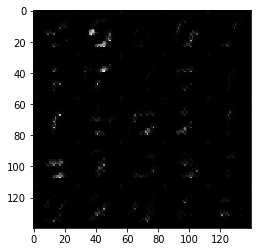

Epoch 1/2... Discriminator Loss: 2.3414... Generator Loss: 0.2659
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 2.7512... Generator Loss: 2.9953
Epoch 1/2... Discriminator Loss: 2.0658... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 2.3688... Generator Loss: 2.6821


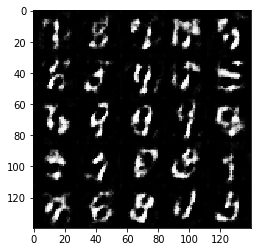

Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 1.7507... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.9380... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.7894... Generator Loss: 0.5266


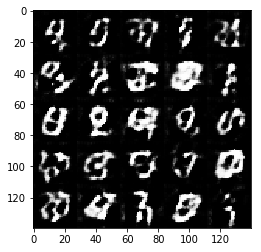

Epoch 1/2... Discriminator Loss: 2.2245... Generator Loss: 2.0716
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 1.4693... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.7207... Generator Loss: 0.5466


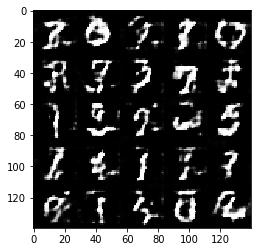

Epoch 1/2... Discriminator Loss: 1.7376... Generator Loss: 1.6086
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.9611... Generator Loss: 1.4769
Epoch 1/2... Discriminator Loss: 1.8499... Generator Loss: 1.3093


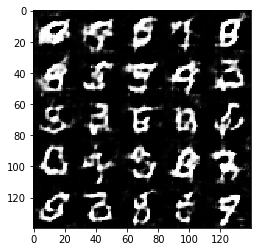

Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 2.6922... Generator Loss: 2.7223
Epoch 1/2... Discriminator Loss: 2.5873... Generator Loss: 2.5385
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.5048
Epoch 1/2... Discriminator Loss: 1.7414... Generator Loss: 0.4943


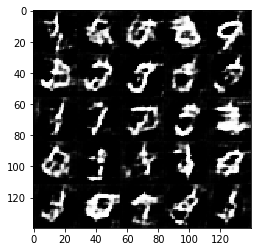

Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.6210... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.9362... Generator Loss: 0.3004
Epoch 1/2... Discriminator Loss: 1.6659... Generator Loss: 0.5373
Epoch 1/2... Discriminator Loss: 1.9284... Generator Loss: 0.3357


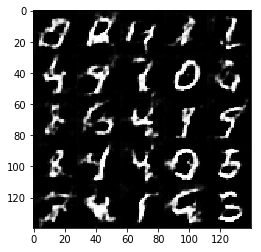

Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 1.4461
Epoch 1/2... Discriminator Loss: 1.7076... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.5714... Generator Loss: 0.4902


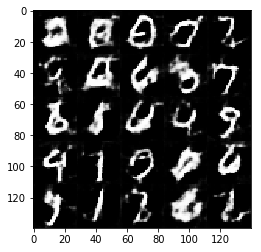

Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.2613
Epoch 1/2... Discriminator Loss: 1.5806... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 2.0607... Generator Loss: 0.2813


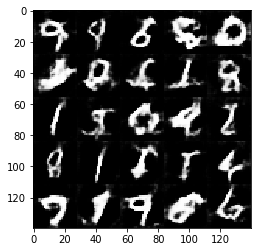

Epoch 1/2... Discriminator Loss: 1.9935... Generator Loss: 0.2962
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.6426... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 1.3125
Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 0.7252


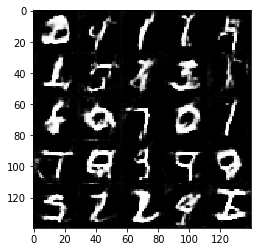

Epoch 2/2... Discriminator Loss: 1.8160... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 1.9988... Generator Loss: 0.2770
Epoch 2/2... Discriminator Loss: 1.5158... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 1.1281


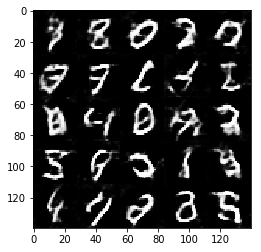

Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 1.9388
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 1.2066


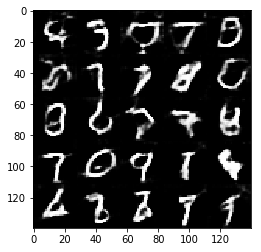

Epoch 2/2... Discriminator Loss: 1.5472... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 1.9478... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 2.1874
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 1.0138


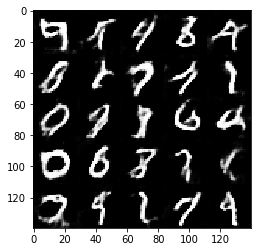

Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.6859
Epoch 2/2... Discriminator Loss: 1.5961... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 1.5513
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 1.3655
Epoch 2/2... Discriminator Loss: 1.8548... Generator Loss: 2.5795


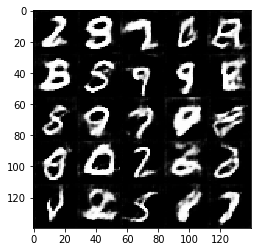

Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 1.4459
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 1.5867... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.8238


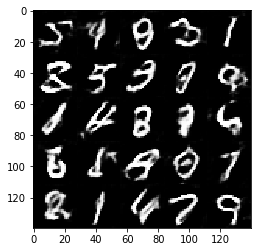

Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.9058
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 1.4232
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 1.7332... Generator Loss: 2.0853
Epoch 2/2... Discriminator Loss: 1.4775... Generator Loss: 0.6141


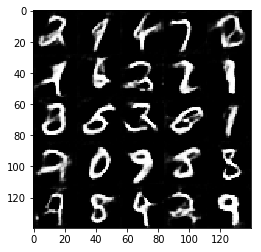

Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 1.6621... Generator Loss: 2.7253
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.7715
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 2.1881


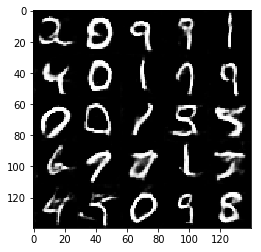

Epoch 2/2... Discriminator Loss: 1.8521... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 2.0558
Epoch 2/2... Discriminator Loss: 1.9039... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.9115
Epoch 2/2... Discriminator Loss: 1.9050... Generator Loss: 1.4691


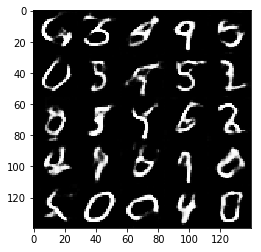

Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 1.5211
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 2.0138


In [53]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5779... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.8091... Generator Loss: 9.1073
Epoch 1/1... Discriminator Loss: 1.7630... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 2.1509


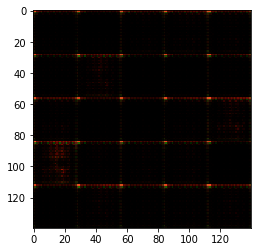

Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 2.7071
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 3.0048
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 2.1303
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 2.1663
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 3.0747


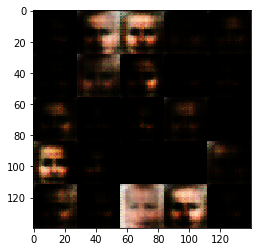

Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 3.6168
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 2.4705


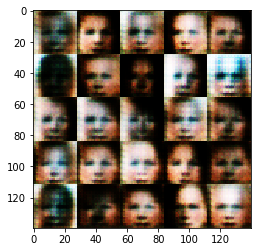

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 1.6660... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.9167


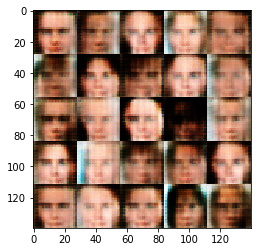

Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 2.7664
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7066


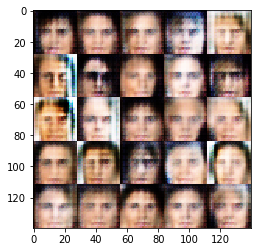

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 2.1184
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.5778


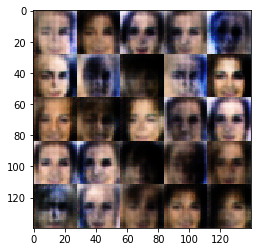

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.4459
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.7297


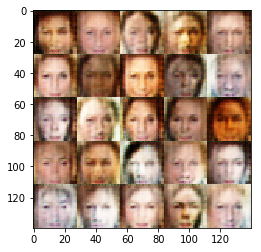

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.2510


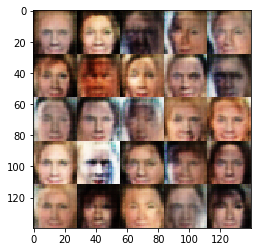

Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6900


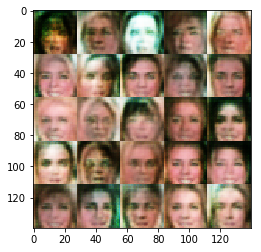

Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 1.0189


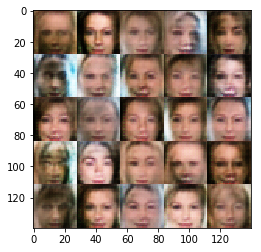

Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.3427
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.9207


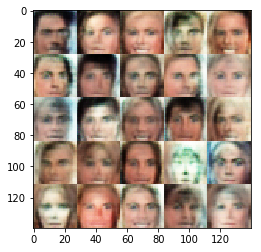

Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.2357
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7009


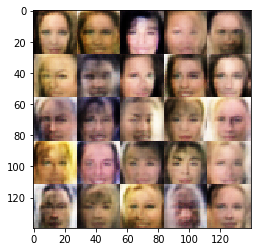

Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.3249


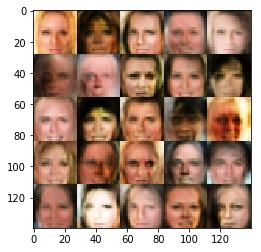

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.3435


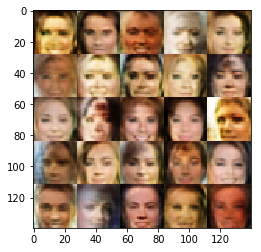

Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 1.6490


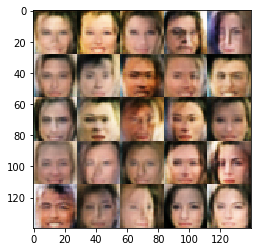

Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 1.7981


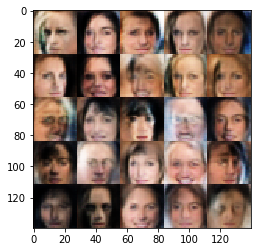

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6541


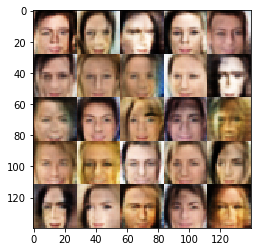

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6909


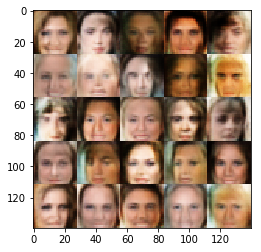

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6041


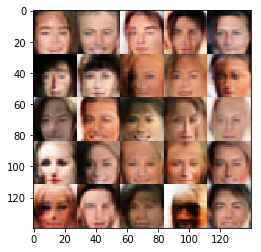

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 1.0111


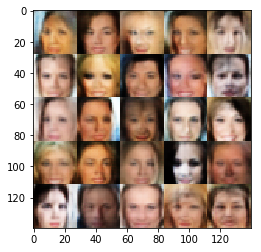

Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 1.0585


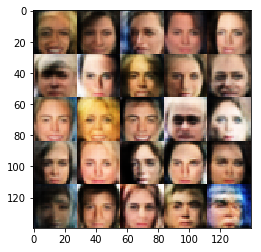

Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.2393


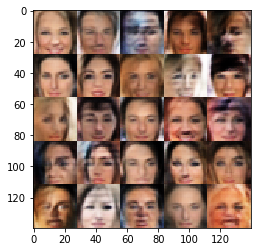

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.1056


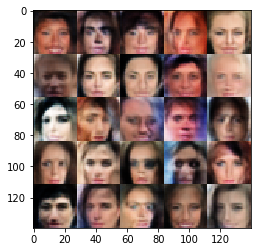

Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.2032


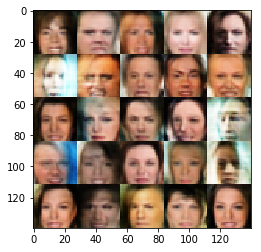

Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.0555


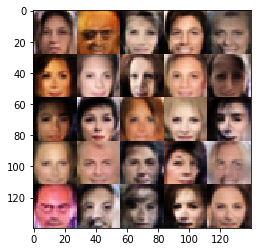

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.0558


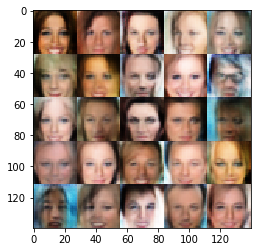

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.3224


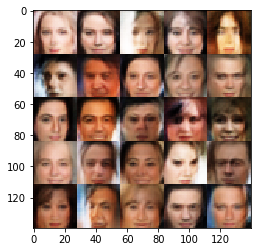

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7369


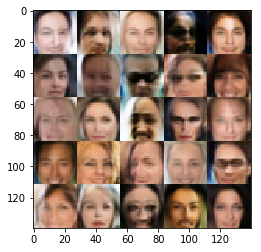

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7001


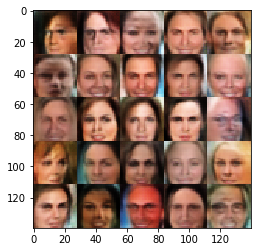

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.9410


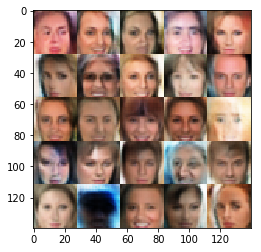

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8445


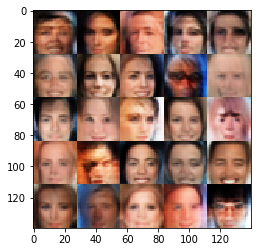

Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7556


In [54]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.